In [1]:
import math
import matplotlib.pyplot as pp
import numpy as np
import pandas as pd
import seaborn as sb

np.random.seed(0)
%matplotlib inline

In [2]:
def load_dataset(path):
    return pd.read_csv(path)

data = load_dataset('data/development.csv')
data_score = load_dataset('data/submission.csv')

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data_score.info()
data_score.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
def collect_statistics(data):
    count = len(data.columns)
    missing_counts = np.zeros(count, dtype=np.uint32)
    unique_counts = np.zeros(count, dtype=np.uint32)
    zero_counts = np.zeros(count, dtype=np.uint32)
    for (i, column) in enumerate(data.columns):
        missing_counts[i] = data[column].isnull().sum()
        unique_counts[i] = data[column].unique().size
        zero_counts[i] = (data[column] == 0).astype(int).sum()
    return pd.DataFrame({
        'Column': data.columns,
        'Unique': unique_counts,
        'Missing': missing_counts,
        'Zero': zero_counts,
    })

In [6]:
collect_statistics(data)

,Column,Missing,Unique,Zero
0,PassengerId,0,891,0
1,Survived,0,2,549
2,Pclass,0,3,0
3,Name,0,891,0
4,Sex,0,2,0
5,Age,177,89,0
6,SibSp,0,7,608
7,Parch,0,7,678
8,Ticket,0,681,0
9,Fare,0,248,15


In [7]:
collect_statistics(data_score)

,Column,Missing,Unique,Zero
0,PassengerId,0,418,0
1,Pclass,0,3,0
2,Name,0,418,0
3,Sex,0,2,0
4,Age,86,80,0
5,SibSp,0,7,283
6,Parch,0,8,324
7,Ticket,0,363,0
8,Fare,1,170,2
9,Cabin,327,77,0


In [8]:
def round(value, precision=10000):
    return math.ceil(value * precision) / precision

def inspect_correlation(data, target, limit=10):
    for column in data.columns:
        if column == target: continue
        correlation = None
        if pd.api.types.is_numeric_dtype(data[column]):
            correlation = round(data[column].corr(data[target]))
        elif data[column].unique().size < limit:
            dummies = pd.get_dummies(data[column])
            correlation = [dummies[column].corr(data[target]) for column in dummies.columns]
            correlation = [round(value) for value in correlation]
        print('{}: {} correlation'.format(column, correlation))

inspect_correlation(data, 'Survived')

PassengerId: -0.005 correlation
Pclass: -0.3384 correlation
Name: None correlation
Sex: [0.5434, -0.5433] correlation
Age: -0.0772 correlation
SibSp: -0.0353 correlation
Parch: 0.0817 correlation
Ticket: None correlation
Fare: 0.2574 correlation
Cabin: None correlation
Embarked: [0.1683, 0.0037, -0.1556] correlation


In [9]:
def compose_person(data):
    age, sex = data
    return 'Child' if age < 16 else sex.capitalize()

def compose_class(data):
    data = data[0]
    if data == 1: return 'Upper'
    elif data == 2: return 'Middle'
    elif data == 3: return 'Lower'
    raise 'Unknown class'

def fix_missing(data, column):
    mean = data[column].mean()
    deviation = data[column].std()
    count = data[column].isnull().sum()
    rand = np.random.randint(mean - deviation, mean + deviation, size=count)
    data.loc[np.isnan(data[column]), column] = rand
    return count

def prepare(data, columns=['PassengerId', 'Survived', 'Age', 'Person', 'Class']):
    fix_missing(data, 'Age')
    data['Age'] = data['Age'].astype(int)
    data['Person'] = data[['Age', 'Sex']].apply(compose_person, axis=1)
    data['Class'] = data[['Pclass']].apply(compose_class, axis=1)
    data.drop(list(set(data.columns.values) - set(columns)), axis=1, inplace=True)

prepare(data)
prepare(data_score)

data.head()

,PassengerId,Survived,Age,Person,Class
0,1,0,22,Male,Lower
1,2,1,38,Female,Upper
2,3,1,26,Female,Lower
3,4,1,35,Female,Upper
4,5,0,35,Male,Lower


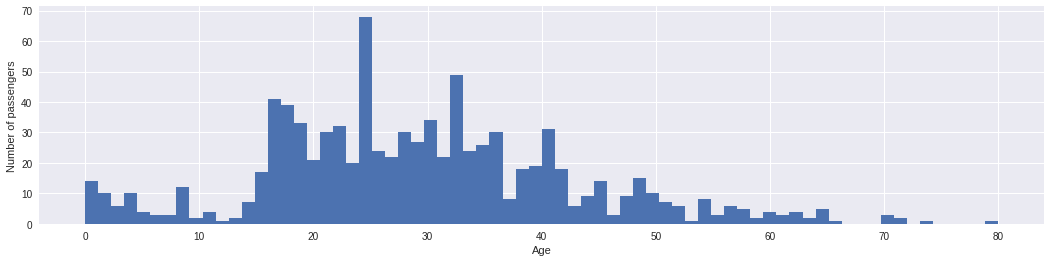

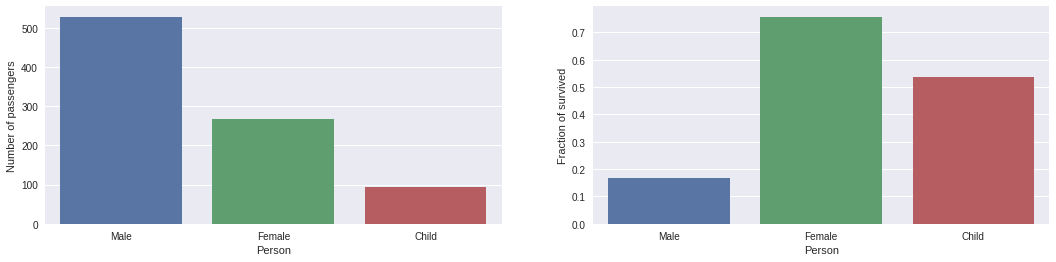

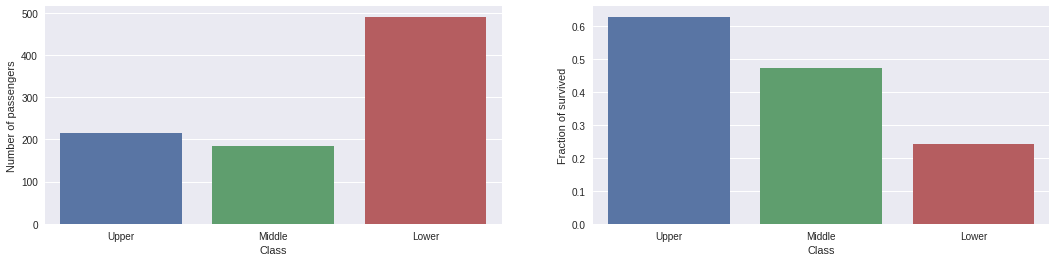

In [10]:
def plot_histogram(data, column):
    figure = pp.figure(figsize=(18, 4))
    data[column].hist(bins=70)
    pp.xlabel(column)
    pp.ylabel('Number of passengers')

def plot_survived(data, column, order):
    figure, axes = pp.subplots(1, 2, figsize=(18, 4))
    sb.countplot(x=column, data=data, ax=axes[0], order=order)
    data = data[[column, 'Survived']].groupby([column], as_index=False).mean()
    sb.barplot(x=column, y='Survived', data=data, ax=axes[1], order=order)
    axes[0].set_ylabel('Number of passengers')
    axes[1].set_ylabel('Fraction of survived')

plot_histogram(data, 'Age')
plot_survived(data, 'Person', ['Male', 'Female', 'Child'])
plot_survived(data, 'Class', ['Upper', 'Middle', 'Lower'])

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
def make_dummies(data, mapping):
    for column in mapping:
        dummies = pd.get_dummies(data[column])
        dummies.columns = mapping[column]
        data = data.join(dummies)
    data.drop(mapping.keys(), inplace=True, axis=1)
    return data

mapping = {
    'Person': ['Male', 'Female', 'Child'],
    'Class': ['Upper', 'Middle', 'Lower'],
}

data = make_dummies(data, mapping)
data_score = make_dummies(data_score, mapping)

data.head()

,PassengerId,Survived,Age,Male,Female,Child,Upper,Middle,Lower
0,1,0,22,0,0,1,1,0,0
1,2,1,38,0,1,0,0,0,1
2,3,1,26,0,1,0,1,0,0
3,4,1,35,0,1,0,0,0,1
4,5,0,35,0,0,1,1,0,0


In [13]:
x = data.drop(['PassengerId', 'Survived'], axis=1)
y = data['Survived']

x_train, y_train = x, y

x_score = data_score.drop('PassengerId', axis=1)

In [14]:
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)

print('Score: {:.4}'.format(model.score(x_train, y_train)))

Score: 0.8676


In [15]:
data_score = pd.DataFrame({
    'PassengerId': data_score['PassengerId'],
    'Survived': model.predict(x_score),
})
data_score.to_csv('solution.csv', index=False)